# Testing the performance of the shape difference calculation and rotation calculation
## Goals of notebook
* Assigning confidence to angle estimates. The vector produced while searching for the minimal shape difference gives us an idea of the quality of the rotation estimate. When the shapes are fairly dissimilar (or too symmetric), then the minimum in the shape difference - angle curve is going to be shallow, wide, or non-unique. Thus, we can examine this curve to see if there is a reportable best-fit rotation angle.
* The information returned by matchcorr can indicate which measurements are possible. It's always possible to measure the minimum shape difference and the psi-s correlation. The rotation should only be reported if it's a unique fit and if the confidence interval is small enough.
* Need to determine the uncertainty of the minimum shape difference, and test whether it is a function of any of the floe parameters. If it is possible, we should parameterize the statistic. I'm not sure what it "should" be from first principles, though. 
* From a few example cases, it looks like there is a bias in the angle measurement that probably comes from finding the minimum in a sorted list. This will tend to choose a smaller angle. Could we do the following? (1) Find the minimum. (2) Look for other points within the confidence interval for the minimum. 

In [152]:
using Pkg
Pkg.activate("calval")
Pkg.add(["IceFloeTracker", "DataFrames", "Images", "ImageSegmentation", "CSV", "Plots","CairoMakie"])

  Activating project at `~/Documents/research/calval_tgrs/notebooks/calval`
   Resolving package versions...
  No Changes to `~/Documents/research/calval_tgrs/notebooks/calval/Project.toml`
  No Changes to `~/Documents/research/calval_tgrs/notebooks/calval/Manifest.toml`
Precompiling project...
   5714.7 ms  ✓ CSV
  1 dependency successfully precompiled in 7 seconds. 471 already precompiled.


In [4]:
using IceFloeTracker

[ Info: Precompiling IceFloeTracker [04643c7a-9ac6-48c5-822f-2704f9e70bd3] (cache misses: wrong dep version loaded (2), dep missing source (4))


In [5]:
using Plots
using Images

[ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80] (cache misses: wrong dep version loaded (6))
[ Info: Precompiling FileIOExt [f5f51d8f-5827-5d2e-939b-192fcd6ec70c] (cache misses: wrong dep version loaded (6))
[ Info: Precompiling IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a] (cache misses: wrong dep version loaded (2))


# Test cases
There are some basic shapes where we can say exactly what the shape difference should be, such as rectangles, ellipses, and triangles. I've done some work on these already, and can update the results as I go. I can also use some of the labeled images for these tests.

In [12]:
maximum(1, 2)

LoadError: MethodError: objects of type Int64 are not callable
The object of type `Int64` exists, but no method is defined for this combination of argument types when trying to treat it as a callable object.
Maybe you forgot to use an operator such as [36m*, ^, %, / etc. [39m?

# Rectangle test case


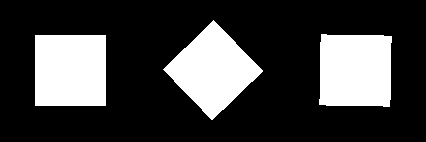

In [36]:
function make_rectangle(area, aspect_ratio, angle_degrees)
    width = round(sqrt(area / aspect_ratio))
    height = round(aspect_ratio * width)
    box = Int32(maximum([width, height]) * 2)
    R = falses((box, box))
    center = Int32(round(box/2))
    hdims = Int64(round(center - height/2)):Int64(round(center + height/2 - 1))
    wdims = Int64(round(center - width/2)):Int64(round(center + width/2 - 1))
    R[hdims, wdims] .= true
    return IceFloeTracker.imrotate_bin_clockwise_degrees(R, angle_degrees)
end

R0 = make_rectangle(5000, 1, 0)
R45 = make_rectangle(5000, 1, 46)
R90 = make_rectangle(5000, 1, 91)
Images.mosaicview(Gray.(R0), Gray.(R45), Gray.(R90), nrow=1)

In [37]:
IceFloeTracker.matchcorr(R0, R45, 10.)

(mm = 0.0, c = 0.9772594244505538)

The register function works well, though it defaults to 5 degree precision.

In [38]:
rad2deg(IceFloeTracker.register(R0, R90)), rad2deg(IceFloeTracker.register(R0, R45))

(0.0, -45.0)

In [42]:
test_angles = deg2rad.(0:5:180)
sd = IceFloeTracker.shape_difference_rotation(R0, R90, test_angles);
angles = [x.angle for x in sd]
shape_diffs = [x.shape_difference for x in sd];

In [43]:
function mismatch_temp(fixed::AbstractArray, moving::AbstractArray, test_angles::AbstractArray)
    shape_differences = IceFloeTracker.shape_difference_rotation(
        fixed, moving, test_angles; imrotate_function=IceFloeTracker.imrotate_bin_clockwise_degrees
    )
    best_match = argmin((x) -> x.shape_difference, shape_differences)
    rotation_degrees = best_match.angle
    normalized_area = (sum(fixed) + sum(moving)) / 2
    normalized_mismatch = best_match.shape_difference / normalized_area
    return (mm=normalized_mismatch, rot=rotation_degrees, sd=best_match.shape_difference)
end
mismatch_temp(R0, R90, rad2deg.(test_angles))

(mm = 0.010315413608411029, rot = 0.0, sd = 52.0)

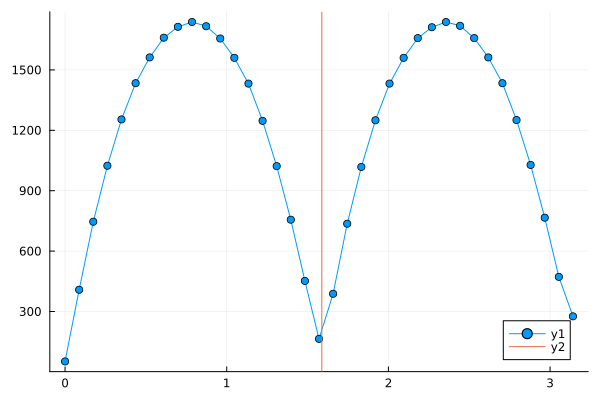

In [45]:
plot(angles, shape_diffs, marker=:circle)
vline!([deg2rad(91)])

For the rectangle case, and a simple 90 degree rotation, there shouldn't be any interpolation effects, and the shape difference minimum is close to 0. To look at the effect of the spline interpolation for intermediate rotations, we calculate the minimum shape difference for intermediate angles.

In [46]:
test_angles = 0:1:90
sd_test(a) = begin
    Rtheta = IceFloeTracker.imrotate_bin_clockwise_degrees(R0, a)
    mm, rot, sd = mismatch_temp(R0, Rtheta, -45:1:135)
    sd
end

minimum_shape_difference = sd_test.(test_angles);

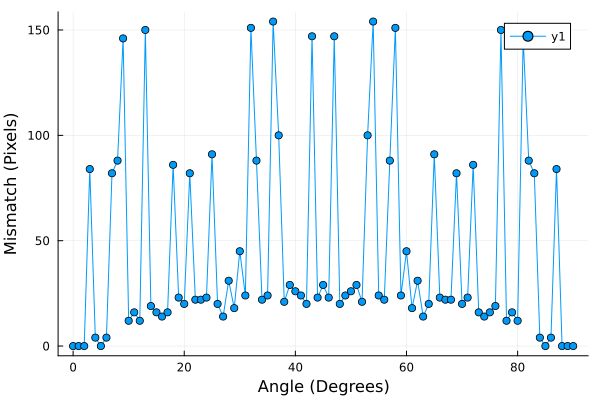

In [47]:
# Multiply by L*H since mismatch_temp returns SD / mean(area1, area2)
plot(test_angles, minimum_shape_difference,
    ylabel="Mismatch (Pixels)", xlabel="Angle (Degrees)", marker=:circle)

In [50]:
area, perimeter = IceFloeTracker.regionprops_table(label_components(R0), properties=["area", "perimeter"])[1,:]

Row,area,perimeter
,Float64,Float64
1,5041.0,280.0


In [57]:
Pkg.resolve()

   Resolving package versions...
    Updating `~/Documents/research/calval_tgrs/notebooks/calval/Project.toml`
  [2913bbd2] + StatsBase v0.34.6
  No Changes to `~/Documents/research/calval_tgrs/notebooks/calval/Manifest.toml`
Precompiling project...
    730.9 ms  ✓ libsixel_jll
    958.7 ms  ✓ libwebp_jll
   1023.2 ms  ✓ WeakRefStrings
   1432.1 ms  ✓ OpenSSL
   1920.5 ms  ✓ ImageMagick_jll
   1464.9 ms  ✓ Sixel
   2330.9 ms  ✓ KernelDensity
   1432.5 ms  ✓ WebP
   2725.7 ms  ✓ Pango_jll
   3884.0 ms  ✓ Qt6ShaderTools_jll
   1997.0 ms  ✓ ImageMagick
    821.2 ms  ✓ Cairo
    760.1 ms  ✓ Qt6Declarative_jll
   5989.9 ms  ✓ CSV
   7105.0 ms  ✓ HTTP
    801.3 ms  ✓ FileIO → HTTPExt
  28345.9 ms  ✓ Plots → UnitfulExt
  28440.7 ms  ✓ Plots → GeometryBasicsExt
  72997.4 ms  ✓ Makie
   5176.8 ms  ✓ Polynomials → PolynomialsMakieExt
   5222.4 ms  ✓ GeoInterface → GeoInterfaceMakieExt
  18009.9 ms  ✓ ArchGDAL → ArchGDALMakieExt
  23819.9 ms  ✓ CairoMakie
  23 dependencies successfully precompile

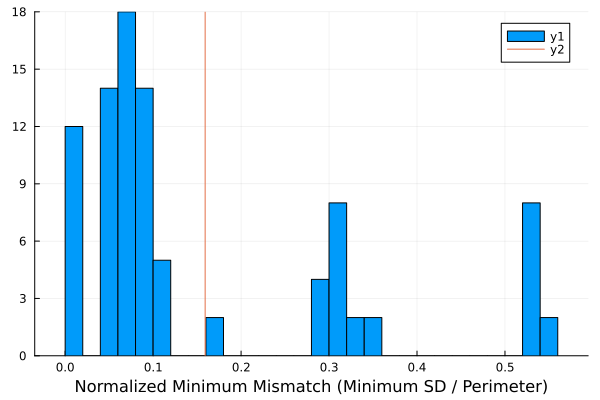

In [59]:
using StatsBase
histogram(minimum_shape_difference / perimeter, xlabel="Normalized Minimum Mismatch (Minimum SD / Perimeter)", bins=30)
vline!([mean(minimum_shape_difference / perimeter)])

# Rectangle experiment
We examine the minimum shape difference error by running the following simulation. For a given area and aspect ratio,
1. Select two random orientations between -45 and 45, these will be floe 1 and floe 2
2. Generate a rectangle at each orientation
3. Find the best rotation and shape difference using a 1 degree step size

To relate this to 

In [116]:
length([50, 100, 500, 1000, 2000, 5000, 10000, 20000])

8

In [131]:
area = [50, 100, 500, 1000, 2000, 5000, 10000, 20000]
aspect = [1.1, 1.5, 2., 2.5]
n = 200
n_cases = n * length(area) * length(aspect)
areas = zeros(n_cases)
aspects = zeros(n_cases)
floe1_theta = zeros(n_cases)
floe2_theta = zeros(n_cases)
recovered_theta = zeros(n_cases)
minimum_sd = zeros(n_cases)
@time begin
    row = 0
    for A in area
        for AR in aspect
            for idx in range(1, n)
                row += 1
                theta1, theta2 = 45 .* (rand(2) .- 0.5)
                floe1_theta[row] = theta1
                floe2_theta[row] = theta2
                R1 = make_rectangle(A, AR, theta1)
                R2 = make_rectangle(A, AR, theta2)
                mm, rot, sd = mismatch_temp(R1, R2, -100:1:100) # maximum difference between angles is 90
                recovered_theta[row] = rot
                minimum_sd[row] = sd
                areas[row] = A
                aspects[row] = AR
            end
        end
    end
end

478.779987 seconds (69.62 M allocations: 798.769 GiB, 5.44% gc time)


In [132]:
results = DataFrame(
    area=areas,
    aspect=aspects,
    floe1_theta=floe1_theta,
    floe2_theta=floe2_theta,
    recovered_theta=recovered_theta,
    minimum_sd=minimum_sd)
results[:, "true_theta"] = floe2_theta .- floe1_theta;
results[:, "perimeter"] .= 0

for A in area
    for AR in aspect
        # using estimated perimeter rather than exact
        perimeter = IceFloeTracker.regionprops_table(
            label_components(make_rectangle(A, AR, 0)),
            properties=["perimeter"])[1,"perimeter"]
        results[results.area .== A .&& results.aspect .== AR, :perimeter] .= perimeter
    end
end

In [156]:
Pkg.instantiate()

Precompiling project...
   5744.0 ms  ✓ CSV
  1 dependency successfully precompiled in 6 seconds. 471 already precompiled.


In [162]:
using Base
Base.retry_load_extensions()
using CSV
CSV.write("../data/rotation_test/rectangle-rotation-shape_difference.csv", results);

[ Info: Precompiling CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b] (cache misses: wrong dep version loaded (4))
┌ Warning: Module ParsersExt with build ID fafbfcfd-b63b-dac7-0000-4ea13e6f5502 is missing from the cache.
│ This may mean ParsersExt [f526588d-e68b-5dc5-a62e-ff9f36e48b1a] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:2541
┌ Error: Error during loading of extension ParsersExt of InlineStrings, use `Base.retry_load_extensions()` to retry.
│   exception =
│    1-element ExceptionStack:
│    Error when precompiling module, potentially caused by a __precompile__(false) declaration in the module.
│    Stacktrace:
│      [1] _require(pkg::Base.PkgId, env::Nothing)
│        @ Base ./loading.jl:2545
│      [2] __require_prelocked(uuidkey::Base.PkgId, env::Nothing)
│        @ Base ./loading.jl:2388
│      [3] #invoke_in_world#3
│        @ ./essentials.jl:1089 [inlined]
│      [4] invoke_in_world
│        @ ./essentials.jl:1086 [inlined]
│    

LoadError: Failed to precompile CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b] to "/Users/dmw/.julia/compiled/v1.11/CSV/jl_orvmdq".

* To add: get the true perimeter for each area / aspect ratio combination
* Figure: there are 32 combinations of area/aspect ratio cases. We need to see how the uncertainty in the recovered theta relates to these parameters. Eventually, this can be a reference point to whether my idea with the size of the minimum trough can let us recover an estimate of the uncertainty.
* We also want to see whether the variation in minimum SD is constant after accounting for the perimeter.
* I'll need to set up a similar experiment to use the true floe shapes, extending the script for the ADR tests to include shape difference and correlation under rotation, and shape difference and correlation under paired floes. These results are what are especially critical for finishing the description of the tracking algorithm.

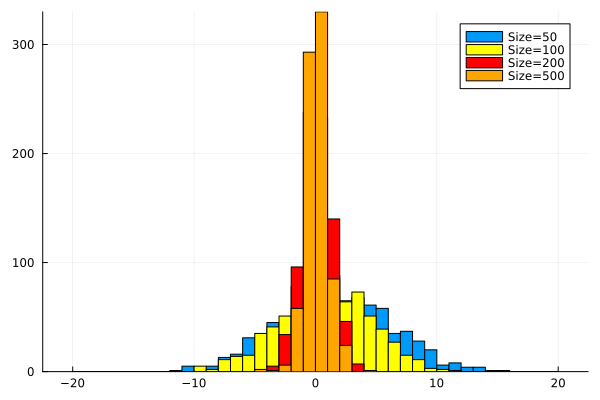

In [149]:
bins = -20:20
idx = results[:,:area] .== 50
histogram(results[idx, "true_theta"] .- results[idx, "recovered_theta"],
    bins=bins, label="Size=50")

idx = results[:,:area] .== 100
histogram!(results[idx, "true_theta"] .- results[idx, "recovered_theta"],
    color=:yellow, bins=bins, label="Size=100")

idx = results[:,:area] .== 500
histogram!(results[idx, "true_theta"] .- results[idx, "recovered_theta"],
    color=:red, bins=bins, label="Size=200")

idx = results[:,:area] .== 1000
histogram!(results[idx, "true_theta"] .- results[idx, "recovered_theta"],
    color=:orange, bins=bins, label="Size=500")

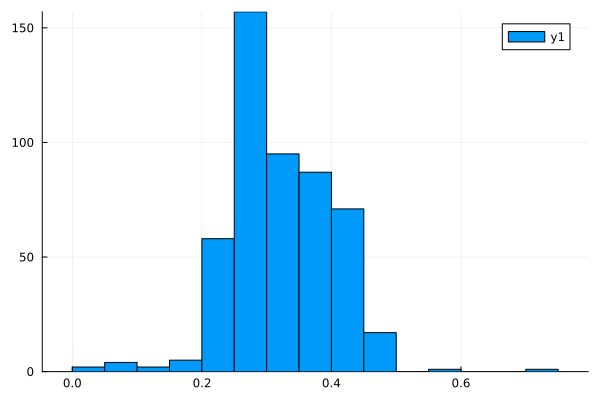

# Results
For the rectangle with dimensions 50 by 100 (equiv to a 18 km length scale floe), the absolute SD error ranges from 0 to 40 pixels. It is clearly a function of angle, with a maximum at 45 degrees and minimuma at 0 and 90. If we consider the perimeter to be the correct reference point, since the errors are likely to accumulate along the boundary, this means that the mismatch error maximum is about 5-10 percent. This held true whilst changing the rectangle size to 150 by 200.

## Floes from test directory

In [118]:
# read labeled image and extract floe properties

4-element Vector{Matrix{Bool}}:
 [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]
 [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]
 [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]
 [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]

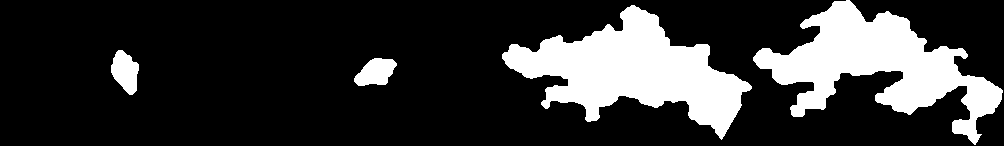

In [119]:
Images.mosaicview([Gray.(x) for x in floes], nrow=1)

In [183]:
test_angles = 0:1:179
sd_test(a) = begin
    ftheta = IceFloeTracker.imrotate_bin_nocrop(floes[2], deg2rad(a))
    f1, f2 = IceFloeTracker.align_centroids(floes[2], ftheta)
    mm, rot, sd = mismatch_temp(floes[1], ftheta, test_angles)
    return sd
end
minimum_shape_difference = sd_test.(test_angles);

In [191]:
test_angles = 0:1:179
rot_test(a) = begin
    ftheta = IceFloeTracker.imrotate_bin_nocrop(floes[2], deg2rad(a))
    f1, f2 = IceFloeTracker.align_centroids(floes[2], ftheta)
    mm, rot, sd = mismatch_temp(floes[2], ftheta, test_angles)
    return rot
end
rotation_accuracy = rot_test.(test_angles);

In [193]:
tab = IceFloeTracker.regionprops_table(label_components(floes[1]), properties=["area", "perimeter"])

Row,area,perimeter
,Float64,Float64
1,841.0,117.397


In the above experiment, the angle in the $x$ axis is the starting angle, and the Mismatch / Perimeter is the minimum value after the optimal rotation. Why is there a peak at 90 degrees? Does the function find the correct angle?

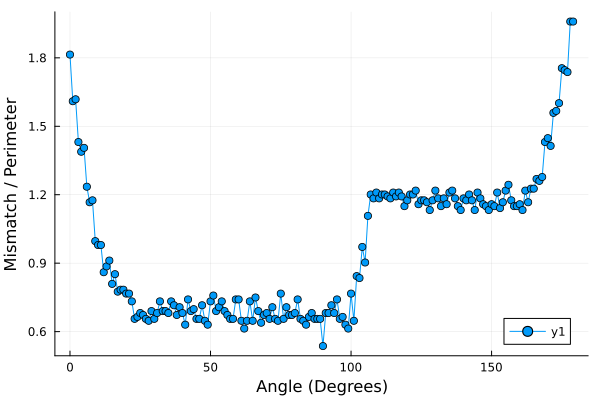

In [194]:
plot(test_angles, minimum_shape_difference / tab.perimeter, ylabel="Mismatch / Perimeter", xlabel="Angle (Degrees)", marker=:circle)

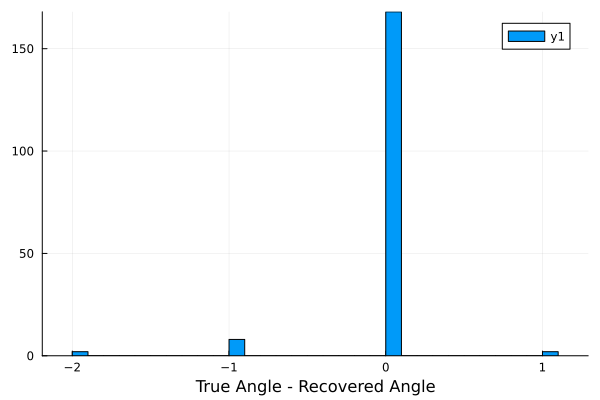

In [196]:
histogram(test_angles, rotation_accuracy .- test_angles, bins=30, xlabel="True Angle - Recovered Angle")

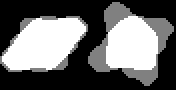

In [201]:
ftheta = IceFloeTracker.imrotate_bin_nocrop(floes[2], deg2rad(180))
f1, f2 = IceFloeTracker.align_centroids(floes[2], ftheta)
ftheta2 = IceFloeTracker.imrotate_bin_nocrop(floes[2], deg2rad(90))
f1a, f3 = IceFloeTracker.align_centroids(floes[2], ftheta2)
Images.mosaicview(0.5 .* Gray.(f1) .+ 0.5 .* Gray.(f2), 
    0.5 .* Gray.(f1a) .+ 0.5 .* Gray.(f3),
    nrow=1)

In [208]:
test_angles = deg2rad.(0:1:135)
sd = IceFloeTracker.shape_difference_rotation(f1a, f3, test_angles);
angles = [x.angle for x in sd]
shape_diffs = [x.shape_difference for x in sd];

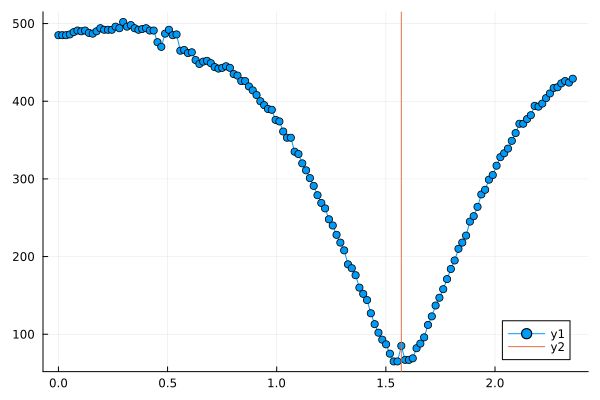

In [209]:
plot(angles, shape_diffs, marker=:circle)
vline!([deg2rad(90)])